In [1]:
import numpy as np
from bayesian_opt import *
from rbf_opt import *
from orthog_poly_opt import *

In [2]:
%matplotlib inline

# Vreman SGS model (1 paramter)

Vreman (2004) model is a recent subgrid-scale (SGS) model for large eddy simulation (LES). Similar to the classic and best-known Smagorinsky (1963) model, the Verman model uses an eddy-viscosity expression to model the unresolved turbulent stress tensor

$$ \tau_{ij} = -2\nu_e\bar{S_{ij}},$$

where $\nu_e$ is the eddy viscosity, and $\bar{S_{ij}}$ is the resolved strain rate tensor.

In the Vreman model, there is a parameter $c\approx 2.5C_S^2$, where $C_S$ is the Smagorinsky constant. We want to find that best $c$ in the sense that it matches the direct numerical simulation (DNS) results best.

Typically $C_S=0.1$ to $0.2$ are used in literature, which corresponds to $c=0.0025$ to $0.1$. Here we choose a slightly large parameter range $[0, 0.14]$ for investigation.

## Bayesian optimization

First we apply the Bayesian optimization to solve the problem. For the initial points, we use the Sobol sequence.

In [3]:
# generate Sobol points
sys.path.append('../HW2')
import seq

c = seq.SobolSeq(8,1).get() * 0.14
print(c)

[[ 0.    ]
 [ 0.07  ]
 [ 0.105 ]
 [ 0.035 ]
 [ 0.0525]
 [ 0.1225]
 [ 0.0875]
 [ 0.0175]]


The DNS/LES problem we are solving here is a supersonic channel flow case. We use the same setup as the DNS of Morinishi et. al (2004) for comparison (bulk Mach number $M_b=1.5$ and bulk Reynolds number $Re_b=3000$). The computational box size is $4\pi h\times 2h \times 4/3\pi h$.

The number of points are $120\times 180\times 120$ for DNS, and are $60\times 120\times 60$ for LES. For the wall-normal direction points, hyperbolic tangent distribution is used.

| Case | $c$    | $Re_b$  | $M_b$ | $Re_{\tau}$ | $M_{\tau}$ | $-B_q$ | 
|------|--------|---------|-------|-------------|------------|--------|
| DNS  | -      | 3011.36 | 1.506 | 219.54      | 0.0800     | 0.0486 |
| 1    | 0      | 3017.41 | 1.518 | 226.49      | 0.0824     | 0.0501 |
| 2    | 0.07   | 3008.80 | 1.504 | 214.87      | 0.0785     | 0.0477 |
| 3    | 0.105  | 3002.50 | 1.501 | 210.96      | 0.0771     | 0.0469 |
| 4    | 0.035  | 3010.70 | 1.505 | 219.27      | 0.0799     | 0.0486 |
| 5    | 0.0525 | 3006.93 | 1.503 | 214.53      | 0.0783     | 0.0476 |
| 6    | 0.1225 | 3005.06 | 1.502 | 208.91      | 0.0764     | 0.0464 |
| 7    | 0.0875 | 3007.05 | 1.504 | 214.07      | 0.0782     | 0.0476 |
| 8    | 0.0175 | 3014.24 | 1.507 | 221.58      | 0.0807     | 0.0491 |

We then read in $y^+$ and $\langle u\rangle^+$ which are calculatd from the DNS and LES data. Since $y^+$ points are not same for different cases, we interpolate them to a single $y^+$ grid by using the spline interpolation.

In [4]:
# read DNS data
dns_y_plus_orig = np.load('data/DNS_y_plus.npy')
dns_u_plus_orig = np.load('data/DNS_u_mean_plus.npy')

# read LES data
def read_les_data(case, q='u_mean_plus'):
    les_y_plus = np.load('data/Case%s_y_plus.npy' % str(case).zfill(2))
    les_u_plus = np.load('data/Case%s_%s.npy' % (str(case).zfill(2), q))
    
    return les_y_plus, les_u_plus

n_cases = c.shape[0]

les_y_plus_orig_list = []
les_u_plus_orig_list = []

for i in range(1,n_cases+1):
    les_y_plus_orig, les_u_plus_orig = read_les_data(i)
    les_y_plus_orig_list.append(les_y_plus_orig)
    les_u_plus_orig_list.append(les_u_plus_orig)

In [5]:
from scipy import interpolate

y_plus = np.logspace(0, np.log(200)/np.log(10), num=100)

def interp(y_plus_orig, data_orig):
    tck = interpolate.splrep(y_plus_orig, data_orig, s=0)
    data = interpolate.splev(y_plus, tck, der=0)
    
    return data

In [6]:
dns_u_plus = interp(dns_y_plus_orig, dns_u_plus_orig)

les_u_plus_list = []
for i in range(n_cases):
    les_u_plus_list.append(interp(les_y_plus_orig_list[i], les_u_plus_orig_list[i]))

Below is the $y^+$ - $\langle u\rangle^+$ plot for the DNS case and one LES case ($c=0$, which is actually an under-resolved DNS case).

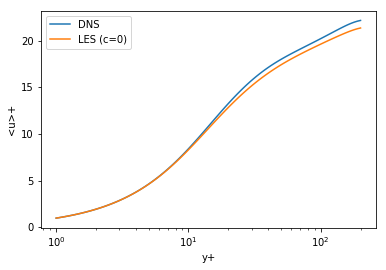

In [7]:
plt.plot(y_plus, dns_u_plus)
plt.plot(y_plus, les_u_plus_list[0])
plt.xlabel('y+')
plt.ylabel('<u>+')
plt.xscale('log')
plt.legend(['DNS', 'LES (c=0)'])

For the optimization problem, we define the cost function as the MSE of the differences in $\langle u\rangle+$.

In [8]:
def cost(les_data, dns_data):
    return np.mean((les_data-dns_data)**2)

In [9]:
costs = []
for i in range(n_cases):
    costs.append(cost(les_u_plus_list[i], dns_u_plus))

In [57]:
bo = BayesianOptimization(bounds=[[0,0.14]], tol=1e-3)
bo.opt_method = 'nelder-mead'

bo.initialize(x=c, y=costs)

After feeding the initial points to the Bayesian optimization sovler, we can obtain the next point to investigate. We can repeat the process until the convergence.

In [58]:
bo.x_next

array([ 0.0371875])

In [59]:
def update_bo(x_next, case_no):
    x_next_cost = cost(interp(*read_les_data(case_no)), dns_u_plus)
    bo.update(x_next_cost, x=np.array([x_next]))
    if bo.converged: print('Converged!')

update_bo(0.0372, 9)

In [60]:
bo.x_next

array([ 0.0243258])

In [61]:
update_bo(0.0243, 10)

In [62]:
bo.x_next

array([ 0.02731809])

In [63]:
update_bo(0.0273, 11)

Converged!


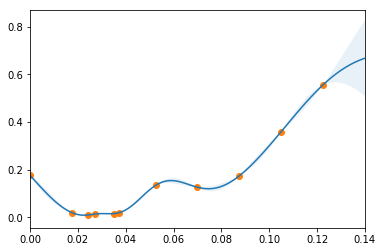

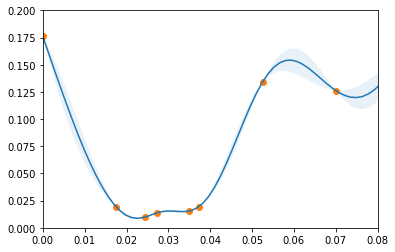

In [64]:
bo.plot()
bo.plot(xmin=0, xmax=0.08, ymin=0, ymax=0.2)

We can then obtain the optimized $c$:

In [65]:
bo.opt_method = 'nelder-mead'
bo.minimize()
print('Best c: %f, Cost: %f' % (bo.xbest, bo.ybest))

Best c: 0.024300, Cost: 0.009748


In [66]:
bo.opt_method = 'anneal'
bo.minimize()
print('Best c: %f, Cost: %f' % (bo.xbest, bo.ybest))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.00   100.00%    40.00%     0:00:02     0:00:00

Best c: 0.024300, Cost: 0.009748


In [68]:
bo.opt_method = 'lm'
bo.minimize()
print('Best c: %f, Cost: %f' % (bo.xbest, bo.ybest))

Best c: 0.024300, Cost: 0.009748


In [69]:
np.sqrt(bo.xbest[0]/2.5)

0.098590060350929903

We find that different optimization methods give the same result in this case. The best $c$ we have is 0.0243, which corresponds to the Smogorinksy constant $C_s\approx 0.1$.

## Radial basis function (RBF) interpolation

Next, we use RBF to approximate the cost function. Two kernels (Gaussian and inverse-quadaratic) are tried.

In [70]:
rbf1 = RBFOptimization(c/max(c), costs, kernel='gaussian')
rbf2 = RBFOptimization(c/max(c), costs, kernel='inverse')

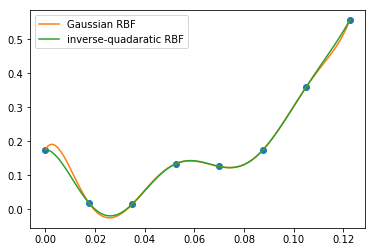

In [71]:
plt.clf()
c_vals = np.linspace(min(c),max(c),num=100)
plt.plot(c, costs, 'o')
plt.plot(c_vals, [rbf1.interpolate(i) for i in c_vals/max(c)], label='Gaussian RBF')
plt.plot(c_vals, [rbf2.interpolate(i) for i in c_vals/max(c)], label='inverse-quadaratic RBF')
#plt.plot(c_vals, [rbfsp(i) for i in c_vals], label='scipy RBF interpolation')
plt.legend(loc='upper left')

In [72]:
bounds = [[0,1]]
rbf2.opt_method = 'nelder-mead'
rbf2.minimize(bounds)
print('Best c: %f, Cost: %f' % (rbf2.xbest*max(c), rbf2.ybest))

Best c: 0.026141, Cost: -0.019261


In [73]:
rbf2.opt_method = 'anneal'
rbf2.minimize(bounds)
print('Best c: %f, Cost: %f' % (rbf2.xbest*max(c), rbf2.ybest))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000          0.14   100.00%    50.00%     0:00:00     0:00:00

Best c: 0.026154, Cost: -0.019261


In [74]:
rbf2.opt_method = 'lm'
rbf2.minimize(bounds)
print('Best c: %f, Cost: %f' % (rbf2.xbest*max(c), rbf2.ybest))

Best c: 0.025840, Cost: -0.019214


The best $c$ we have is 0.0261 (for the inverse-quadaratic RBF case). Then we run another LES case for $c=0.0261$, and the real cost we have is about 0.023, which is larger than the cost we got from the Bayesian optimization.

In [75]:
_, les_u_plus_orig = read_les_data(12)
cost(interp(les_y_plus_orig_list[i], les_u_plus_orig), dns_u_plus)

0.022902407698436669

## Orthogonal polynomials representation

Last, we use the orthogonal polynomials expansion to approximate the cost function, and four families of orthogonal polynomials are used here.

In [76]:
orth1 = OrthogPolyOptimization(c/max(c), costs, rho='uniform', opt_method='nelder-mead')
orth2 = OrthogPolyOptimization(c/max(c), costs, rho='gaussian', opt_method='nelder-mead')
orth3 = OrthogPolyOptimization(c/max(c), costs, rho='beta', opt_method='nelder-mead')
orth4 = OrthogPolyOptimization(c/max(c), costs, rho='gamma', opt_method='nelder-mead')

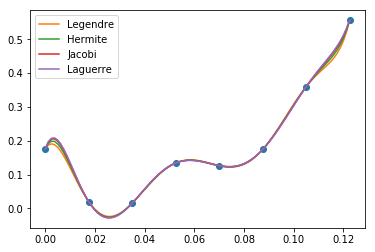

In [77]:
plt.plot(c, costs, 'o')
plt.plot(c_vals, [orth1.predict(i) for i in c_vals/max(c)], label='Legendre')
plt.plot(c_vals, [orth2.predict(i) for i in c_vals/max(c)], label='Hermite')
plt.plot(c_vals, [orth3.predict(i) for i in c_vals/max(c)], label='Jacobi')
plt.plot(c_vals, [orth4.predict(i) for i in c_vals/max(c)], label='Laguerre')
plt.legend(loc='upper left')

In [78]:
orth1.opt_method = 'anneal'
orth1.minimize(bounds)
print('Best c: %f, Cost: %f' % (orth1.xbest*max(c), orth1.ybest))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000          0.14   100.00%    60.00%     0:00:01     0:00:00

Best c: 0.025862, Cost: -0.024188


The best $c$ we have is 0.0259 (for the Legendre polynomial case). Then we run another LES case for $c=0.0259$, and the real cost we have is about 0.028, still larger than the cost from the Bayesian optimization.

In [79]:
_, les_u_plus_orig = read_les_data(13)
cost(interp(les_y_plus_orig_list[i], les_u_plus_orig), dns_u_plus)

0.027571608146748316

Let' also try a different cost function by using a 2nd-order statistics instead of 1st-order statistics - the Reynolds stress component $-\langle\rho u'v'\rangle^+ = -\langle\rho u'v'\rangle/(\rho_w u_{\tau}^2)$.

In [80]:
# DNS
dns_rhouv = interp(dns_y_plus_orig, np.load('data/DNS_uv.npy'))

# LES
les_rhouv_list = []
for i in range(n_cases):
    _, les_rhouv_orig = read_les_data(i+1, q='uv')
    les_rhouv_list.append(interp(les_y_plus_orig_list[i], les_rhouv_orig))

rhouv_costs = []
for i in range(n_cases):
    rhouv_costs.append(cost(les_rhouv_list[i], dns_rhouv))

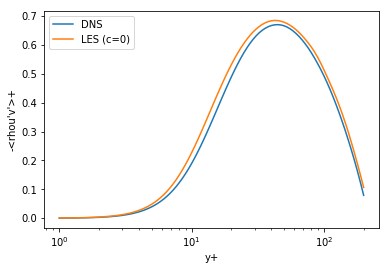

In [81]:
plt.plot(y_plus, dns_rhouv)
plt.plot(y_plus, les_rhouv_list[0])
plt.xlabel('y+')
plt.ylabel("-<rhou'v'>+")
plt.xscale('log')
plt.legend(['DNS', 'LES (c=0)'])

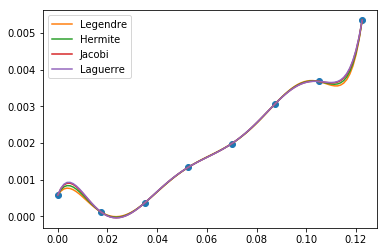

In [82]:
orth1 = OrthogPolyOptimization(c/max(c), rhouv_costs, rho='uniform')
orth2 = OrthogPolyOptimization(c/max(c), rhouv_costs, rho='gaussian')
orth3 = OrthogPolyOptimization(c/max(c), rhouv_costs, rho='beta')
orth4 = OrthogPolyOptimization(c/max(c), rhouv_costs, rho='gamma')

plt.plot(c, rhouv_costs, 'o')
plt.plot(c_vals, [orth1.predict(i) for i in c_vals/max(c)], label='Legendre')
plt.plot(c_vals, [orth2.predict(i) for i in c_vals/max(c)], label='Hermite')
plt.plot(c_vals, [orth3.predict(i) for i in c_vals/max(c)], label='Jacobi')
plt.plot(c_vals, [orth4.predict(i) for i in c_vals/max(c)], label='Laguerre')
plt.legend(loc='upper left')

In [83]:
orth1.opt_method = 'anneal'
orth1.minimize(bounds)
print('Best c: %f, Cost: %f' % (orth1.xbest*max(c), orth1.ybest))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000          0.00   100.00%    30.00%     0:00:01     0:00:00

Best c: 0.023375, Cost: -0.000011


So we see that the best $c$ got from the Reynolds stress cost function is similar to $c$ got before from the mean velocity cost function.

Below is the summary of the additional cases we run.

| Case | $c$    | $Re_b$  | $M_b$ | $Re_{\tau}$ | $M_{\tau}$ | $-B_q$ | 
|------|--------|---------|-------|-------------|------------|--------|
| 9    | 0.0372 | 3010.51 | 1.505 | 218.24      | 0.0796     | 0.0484 |
| 10   | 0.0243 | 3012.60 | 1.506 | 219.31      | 0.0800     | 0.0486 |
| 11   | 0.0273 | 3009.25 | 1.504 | 218.96      | 0.0799     | 0.0485 |
| 12   | 0.0261 | 3008.67 | 1.504 | 218.60      | 0.0798     | 0.0484 |
| 13   | 0.0259 | 3010.63 | 1.505 | 221.51      | 0.0807     | 0.0490 |

# Vreman SGS model (2 parameters)

The momentum eddy viscosity can be estimated from the Vreman model. But for the energy equation, we need the heat transfer eddy viscosity. We could use the the turbulent Prandtl number $Pr_t$ to obtain the heat transfer eddy viscosity from the momentum eddy viscosity. $Pr_t$ is just defined as the ratio between the two eddy viscosity. The theortical $Pr_t$ obtained from Reynolds analogy is 1, and in the experiments $Pr_t$ typically ranges from 0.7 to 0.9. Here we investigate $Pr_t$ from 0.6 to 1.

Along with the constant $c$ in the Vreman model, now we have 2 parameters to optimize. Again, we use the Sobol sequence to generate the initial points for the Bayesian optimization.

In [84]:
sobol_pts = seq.SobolSeq(8,2).get()

In [85]:
sobol_pts[:,0] *= 0.14 # Vreman C
sobol_pts[:,1] = sobol_pts[:,1] * 0.4 + 0.6 # Pr_t
sobol_pts

array([[ 0.    ,  0.6   ],
       [ 0.07  ,  0.8   ],
       [ 0.105 ,  0.7   ],
       [ 0.035 ,  0.9   ],
       [ 0.0525,  0.75  ],
       [ 0.1225,  0.95  ],
       [ 0.0875,  0.65  ],
       [ 0.0175,  0.85  ]])

In [ ]:
n_cases_2d = sobol_pts.shape[0]

# DNS
dns_t_plus = interp(dns_y_plus_orig, np.load('data/DNS_T_mean_plus.npy'))

# LES
les_2d_u_plus_list = []
for i in range(n_cases_2d):
    _, les_u_plus_orig = read_les_data('B%s'% str(i+1).zfill(2), q='T_mean_plus')
    les_2d_u_plus_list.append(interp(les_y_plus_orig_list[i], les_u_plus_orig))

costs_2d = []
for i in range(n_cases_2d):
    costs_2d.append(cost(les_2d_u_plus_list[i], dns_t_plus))

In [ ]:
normed_params = np.copy(sobol_pts)
normed_params[:,0] /= max(sobol_pts[:,0])
normed_params[:,1] -= min(sobol_pts[:,1])
normed_params[:,1] /= max(sobol_pts[:,1]) - min(sobol_pts[:,1])

In [ ]:
orth_2d = OrthogPolyOptimization(normed_params, np.array(costs_2d).reshape((-1,1)), rho='gaussian')

In [ ]:
bo_2d = BayesianOptimization(bounds=[[0,0.14],[0.6,1.0]], tol=1e-2)
bo_2d.opt_method = 'nelder-mead'

bo_2d.initialize(x=sobol_pts, y=costs_2d)

In [ ]:
bo.x_next

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def generate_2d_points(fun, n):
    x1 = np.linspace(0, 1,num=n)
    x2 = np.linspace(0, 1,num=n)
    x1, x2 = np.meshgrid(x1, x2)
    
    y = np.zeros(x1.shape)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            y[i,j] = fun([x1[i,j], x2[i,j]])

    return x1, x2, y

c_vals, prt_vals, costs_2d_pred = generate_2d_points(orth.predict, 50)

# convert back to real values
c_vals *= max(sobol_pts[:,0])
prt_vals *= max(sobol_pts[:,1]) - min(sobol_pts[:,1])
prt_vals += min(sobol_pts[:,1])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('c')
ax.set_ylabel('Pr_t')
ax.set_zlabel('cost')
ax.plot_surface(c_vals, prt_vals, costs_2d_pred, cmap=cm.RdBu)